In [1]:
suppressMessages(suppressWarnings({
  library(Seurat)
  library(SeuratDisk)
  library(scater)
  library(cowplot)
  library(reticulate)
  }))

In [2]:
ad <- import("anndata", convert = FALSE)
#utiliza la función import() del paquete reticulate en R para cargar el módulo de Python anndata

In [3]:
PT16_ad <- ad$read_h5ad("/data/scratch/LAB/enric/zz_Spatial_Seq_Hudosn/Results/adata_16.h5ad")
#Usa el método read_h5ad() del módulo de Python anndata para leer un archivo .h5ad

In [4]:
PT16_ad

AnnData object with n_obs <U+00D7> n_vars = 1716 <U+00D7> 17354
    obs: 'in_tissue', 'array_row', 'array_col', 'thing', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'thing_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

In [6]:
# Extraer y transponer la matriz de expresión
expression_matrix <- as.matrix(reticulate::py_to_r(PT16_ad$X$todense()))
expression_matrix <- t(expression_matrix)  # Transponer para que los genes estén en filas y las células en columnas

# Convertir los nombres de las variables y observaciones a vectores de caracteres
var_names <- as.character(reticulate::py_to_r(PT16_ad$var_names$to_list()))
obs_names <- as.character(reticulate::py_to_r(PT16_ad$obs_names$to_list()))

# Verificar las longitudes
print(length(var_names))  # Debería ser 17354
print(length(obs_names))  # Debería ser 1716

# Asignar los nombres de las filas y columnas
rownames(expression_matrix) <- var_names
colnames(expression_matrix) <- obs_names

[1] 17354
[1] 1716


In [7]:
# Crear el objeto Seurat con la matriz de expresión
PT16 <- CreateSeuratObject(counts = expression_matrix)

# Verificar el objeto Seurat
print(PT16)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


An object of class Seurat 
17354 features across 1716 samples within 1 assay 
Active assay: RNA (17354 features, 0 variable features)
 1 layer present: counts


In [8]:
# Asignar la capa normalizada con un nombre más descriptivo
PT16 <- SetAssayData(PT16, layer = "normalized", new.data = expression_matrix)

In [9]:
# Verificar el contenido del assay activo
print(PT16@assays$RNA)

Assay (v5) data with 17354 features for 1716 cells
First 10 features:
 AL627309.1, AL627309.5, LINC01409, LINC01128, LINC00115, FAM41C,
LINC02593, SAMD11, NOC2L, KLHL17 
Layers:
 counts, normalized 


In [11]:
# Cargar la imagen espacial desde la carpeta `spatial`
spatial_image <- Read10X_Image("/data/scratch/LAB/enric/zz_Spatial_Seq_Hudosn/Patient_16/Spatial_transcriptomics/Processed_data/spatial/")

In [12]:
# Asignar la imagen al objeto Seurat
PT16@images[["spatial"]] <- spatial_image

# Verificar que la información se haya agregado correctamente
print(PT16@images)

$spatial
Spatial coordinates for 1716 cells
Default segmentation boundary: centroids 
Associated assay: Spatial 
Key: slice1_ 



In [14]:
print("CD4" %in% rownames(PT16))

[1] TRUE


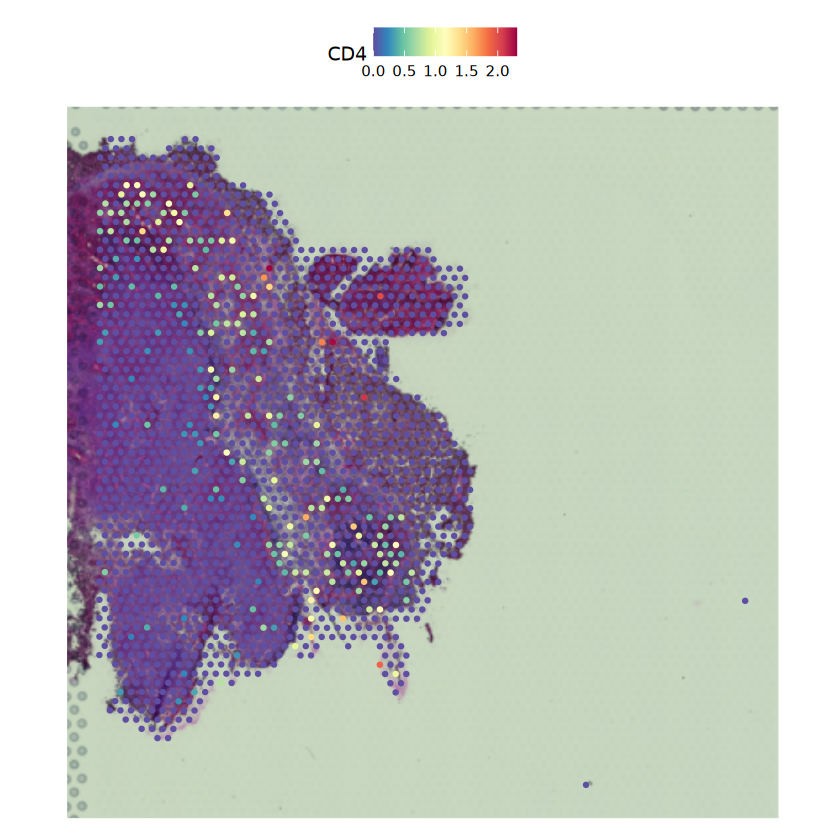

In [15]:
SpatialPlot(PT16, features = "CD4",slot = "normalized")

In [16]:
# Extraer UMAP desde AnnData y convertir a R
umap <- reticulate::py_to_r(PT16_ad$obsm['X_umap'])
rownames(umap) <- obs_names  # Asignar los nombres de las filas
colnames(umap) <- paste0("UMAP_", 1:ncol(umap))  # Nombres de las columnas

# Agregar UMAP a PT16
PT16[["umap"]] <- CreateDimReducObject(embeddings = umap, key = "UMAP_", assay = "RNA")

In [17]:
# Extraer PCA desde AnnData y convertir a R
pca <- reticulate::py_to_r(PT16_ad$obsm['X_pca'])
rownames(pca) <- obs_names  # Asignar los nombres de las filas
colnames(pca) <- paste0("PC_", 1:ncol(pca))  # Nombres de las columnas
# Agregar PCA a PT16
PT16[["pca"]] <- CreateDimReducObject(embeddings = pca, key = "PC_", assay = "RNA")

In [18]:
print(PT16@reductions)

$umap
A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Number of cells: 1716 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 

$pca
A dimensional reduction object with key PC_ 
 Number of dimensions: 21 
 Number of cells: 1716 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 



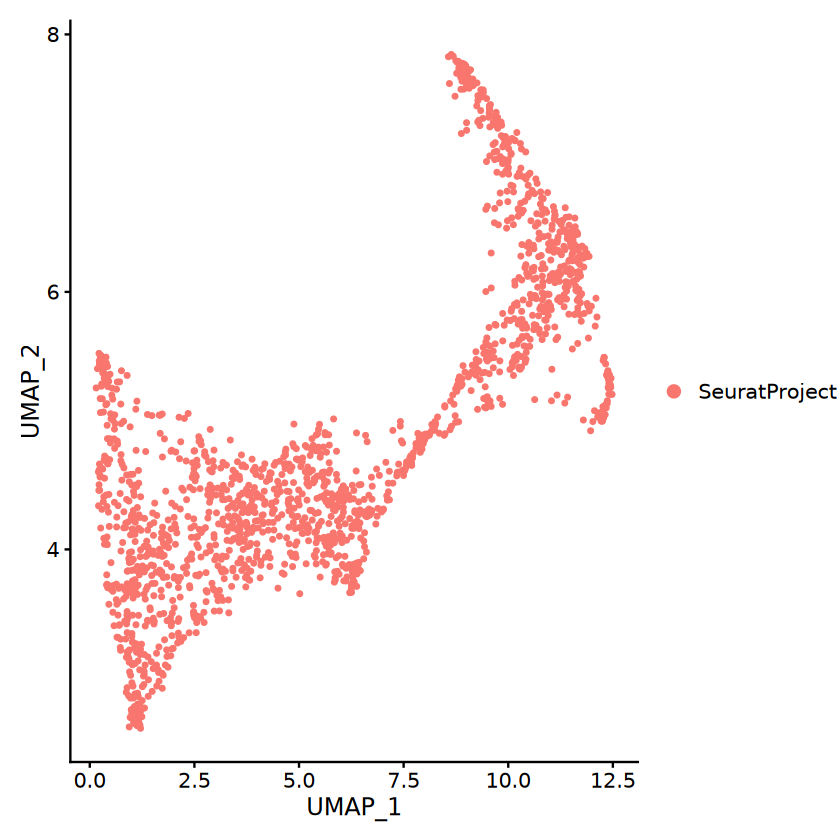

In [19]:
# Graficar UMAP
DimPlot(PT16, reduction = "umap")

In [20]:
# Guardar el objeto Seurat PT16 en un archivo .rds
#saveRDS(PT16, "/data/scratch/LAB/enric/zz_Spatial_Seq_Hudosn/Results/PT16.rds")

In [2]:
# Cargar el objeto Seurat PT16 desde el archivo .rds
PT16 <- readRDS("/data/scratch/LAB/enric/zz_Spatial_Seq_Hudosn/Results/PT16.rds")

# Verificar que el objeto Seurat se haya cargado correctamente
print(PT16)

An object of class Seurat 
17354 features across 1716 samples within 1 assay 
Active assay: RNA (17354 features, 0 variable features)
 2 layers present: counts, normalized
 2 dimensional reductions calculated: umap, pca
 1 spatial field of view present: spatial


In [4]:
# Leer el archivo y usar la primera columna como rownames (barcodes)
clone_counts16 <- read.delim("/data/scratch/LAB/enric/zz_Spatial_Seq_Hudosn/Patient_16/Spatial_TCR/Patient16_output_counts_mixcr3_modified.tsv", 
                             header = TRUE, sep = "\t", row.names = 1)

# Eliminar la columna extra 'X' que está representando la primera columna como "chr"
clone_counts16 <- clone_counts16[, !grepl("X", colnames(clone_counts16))]  # Eliminar la columna con 'X'


# Verificar la estructura del archivo
head(clone_counts16)


,clone35,clone281,clone88,clone487,clone295,clone748,clone512,clone703,clone215,clone249,⋯,clone239,clone238,clone7,clone744,clone544,clone307,clone737,clone4,clone231,clone753
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>
ACGCCTGACACGCGCT,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
TACCGATCCAACACTT,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
ATTAAAGCGGACGAGC,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
GATAAGGGACGATTAG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
GTGCAAATCACCAATA,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
TGTTGGCTGGCGGAAG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA


In [12]:
# Verificar que los barcodes coincidan con el formato 10X (añadir el sufijo "-1" a los rownames de clone_counts16)
rownames(clone_counts16) <- paste(rownames(clone_counts16), "-1", sep="")

# Asegurarse de que las filas de clone_counts16 coincidan con los barcodes de PT16 (en este caso PT16 es el objeto Seurat)
clone_counts16 <- clone_counts16[colnames(PT16),]  # Reordenar las filas de clone_counts16 según las columnas de PT16

# Verificar la estructura del archivo y confirmar que las filas y columnas estén bien alineadas
head(clone_counts16)


,clone35,clone281,clone88,clone487,clone295,clone748,clone512,clone703,clone215,clone249,⋯,clone239,clone238,clone7,clone744,clone544,clone307,clone737,clone4,clone231,clone753
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>
AAACACCAATAACTGC-1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
AAACAGCTTTCAGAAG-1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,NA
AAACAGGGTCTATATT-1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
AAACCGGGTAGGTACC-1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,NA
AAACCGTTCGTCCAGG-1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
AAACCTCATGAAGTTG-1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA


In [17]:
dim(clone_counts16)
# Final clonotype count: 895
# Average number of reads per clonotype: 99.72
# cuadra bien con el archivo de salida de mixcr, 1716 celulas y 895 clonotipos.

[1] 1716  895

In [18]:
# Ahora agregamos los clonotipos como metadatos al objeto Seurat PT16
for(i in 1:ncol(clone_counts16)) {
  PT16 <- AddMetaData(PT16, metadata = clone_counts16[, i], col.name = colnames(clone_counts16)[i])
}

# Verificar que los clonotipos se han añadido correctamente al objeto Seurat
head(PT16@meta.data)  # Mostrar las primeras filas de los metadatos

,orig.ident,nCount_RNA,nFeature_RNA,clone35,clone281,clone88,clone487,clone295,clone748,clone512,⋯,clone239,clone238,clone7,clone744,clone544,clone307,clone737,clone4,clone231,clone753
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>
AAACACCAATAACTGC-1,SeuratProject,2397.261,4088,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
AAACAGCTTTCAGAAG-1,SeuratProject,2354.276,3788,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,NA
AAACAGGGTCTATATT-1,SeuratProject,2424.316,4304,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
AAACCGGGTAGGTACC-1,SeuratProject,2489.581,4306,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,NA
AAACCGTTCGTCCAGG-1,SeuratProject,1767.899,1306,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA
AAACCTCATGAAGTTG-1,SeuratProject,2354.923,4164,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,NA


In [20]:
# Leer los datos de clonotipos de MiXCR
clone_info16 <- read.table("/data/scratch/LAB/enric/zz_Spatial_Seq_Hudosn/Patient_16/Spatial_TCR/Processed_data/mixcr_3_output_hudson/clones.clonotypes.ALL.txt",
                           sep = "\t", header = TRUE, row.names = 1)

# Verificar las primeras filas del archivo de clonotipos
head(clone_info16)


,cloneCount,cloneFraction,targetSequences,targetQualities,allVHitsWithScore,allDHitsWithScore,allJHitsWithScore,allCHitsWithScore,allVAlignments,allDAlignments,⋯,nSeqFR4,minQualFR4,aaSeqFR1,aaSeqCDR1,aaSeqFR2,aaSeqCDR2,aaSeqFR3,aaSeqCDR3,aaSeqFR4,refPoints
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>
0,6756,0.07569663,TGTCAAAAGTATGACAGTGCCCCGCTCACTTTC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,IGKV1-27*00(220.4),,IGKJ4*00(176.6),IGKC*00(776.9),427|450|471|0|23|SA439G|99.0,,⋯,NA,NA,NA,NA,NA,NA,NA,CQKYDSAPLTF,NA,:::::::::0:-1:23:::::22:1:33:::
1,4366,0.04891822,TGCCAACAATATAATAGTCTCCCTCTTACTTTC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,"IGKV1D-16*00(198.3),IGKV1-16*00(194.3)",,IGKJ4*00(167.7),IGKC*00(785.9),354|379|400|0|25|SG362AST372CSA373T|77.0;427|445|471|0|18|SG435A|74.0,,⋯,NA,NA,NA,NA,NA,NA,NA,CQQYNSLPLTF,NA,:::::::::0:-1:25:::::27:-4:33:::
2,3755,0.04207236,TGTCATCAGTATAAGAACTGGCCGCCGTGGACGTTC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,"IGKV3-15*00(221.5),IGKV3D-15*00(205.6)",,IGKJ1*00(192.5),IGKC*00(773),421|444|465|0|23|SG426TST435G|83.0;371|398|417|0|27|SG376TST385GST394G|87.0,,⋯,NA,NA,NA,NA,NA,NA,NA,CHQYKNWPPWTF,NA,:::::::::0:-1:23:::::25:1:36:::
3,3097,0.03469989,TGCCAACAGTATAATAGTTATTCTCGGACGTTC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,IGKV1-5*00(256.6),,IGKJ1*00(177.4),IGKC*00(778),427|451|471|0|24||120.0,,⋯,NA,NA,NA,NA,NA,NA,NA,CQQYNSYSRTF,NA,:::::::::0:0:24:::::25:-2:33:::
4,2733,0.03062151,TGTGCCAGCAGCCCCGAGTTAGGCGGACCCTACGAGCAGTACTTC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TRBV7-6*00(289.8),,TRBJ2-7*00(221.6),TRBC2*00(551.5),430|442|467|0|12||60.0,,⋯,NA,NA,NA,NA,NA,NA,NA,CASSPELGGPYEQYF,NA,:::::::::0:-5:12:::::28:-2:45:::
5,2134,0.02391010,TGTGCCAGCAGCTTAGTGGGGGCAGGGGAGCAGTTCTTC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TRBV7-8*00(309.4),TRBD1*00(30),TRBJ2-1*00(199.2),"TRBC2*00(57.6),TRBC1*00(51.1)",430|446|467|0|16||80.0,18|24|36|17|23||30.0,⋯,NA,NA,NA,NA,NA,NA,NA,CASSLVGAGEQFF,NA,:::::::::0:-1:16:17:-6:0:23:27:-10:39:::


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for alpha is already present.
Adding another scale for alpha, which will replace the existing scale.


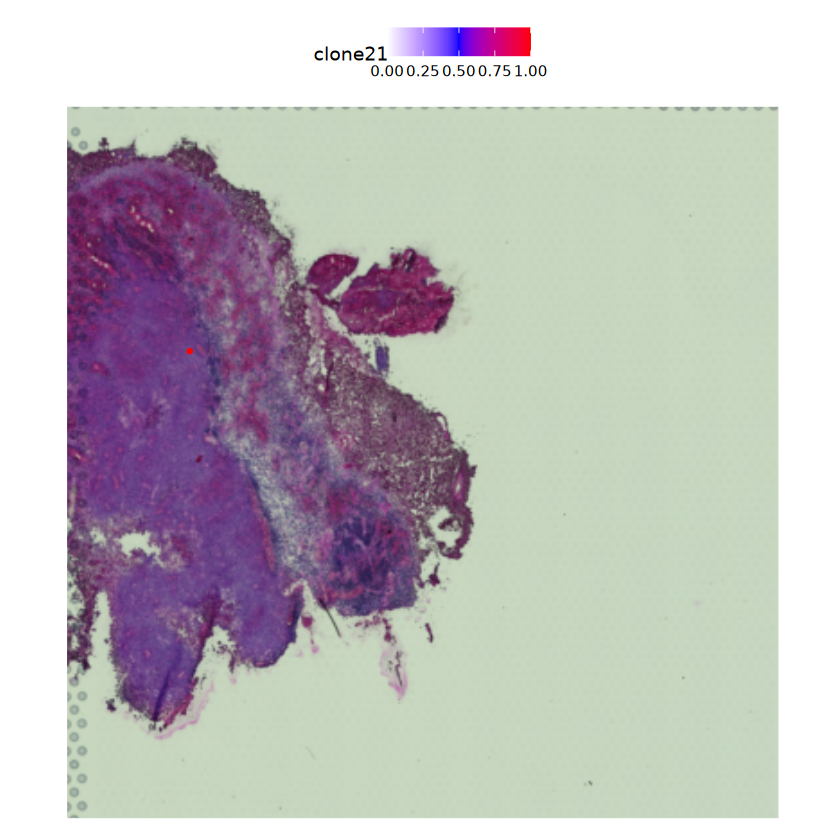

In [21]:
# Asegurarse de que el objeto Seurat tiene los metadatos de clonotipos
# En este caso, asumimos que 'clone_counts16' ya está en PT16 como metadatos

# Crear el gráfico espacial para un clon específico (por ejemplo, "clone21")
SpatialPlot(PT16, features = "clone21") +
  scale_fill_gradient2(low = "white", mid = "blue", high = "red", midpoint = 0.5) +
  scale_alpha_continuous(range = c(0, 1))